In [1]:
# import sys
# import shap
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import xgboost as xgb

# main_path = Path().absolute().parent
# sys.path.append(str(main_path))
# shap.initjs()

# from CAhousing import build_model

# results = build_model(seed=8, eta=0.3, max_depth=8, subsample=1.0, num_rounds=200)
# model = results['model']
# X_train, y_train = results['train']
# X_test, y_test = results['test']

# explainer = shap.TreeExplainer(model)
# shap_values = explainer(X_test)
# shap_interaction_values = explainer.shap_interaction_values(X_test)

[0]	test-rmse:1.43881
[20]	test-rmse:0.47593
[40]	test-rmse:0.46441
[60]	test-rmse:0.46037
[80]	test-rmse:0.45844
[100]	test-rmse:0.45819
[120]	test-rmse:0.45695
[140]	test-rmse:0.45686
[160]	test-rmse:0.45652
[180]	test-rmse:0.45721
[199]	test-rmse:0.45819
# of train data: 18576
# of test data: 2064
R2 square: 0.8452950327375699


In [ ]:
import sys
import shap
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb

main_path = Path().absolute().parent
sys.path.append(str(main_path))
shap.initjs()


In [143]:
from shap.datasets import adult, boston, nhanesi, communitiesandcrime
from sklearn.datasets import fetch_california_housing
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score

class ModelBuilder():
    def __init__(
            self, 
            dataset_name: str, 
            data_folder: str, 
            eta: float=0.3, 
            max_depth: int=8, 
            subsample: float=1.0, 
            seed: int=8
        ):
        self.loaders = {
            'adult': (adult, 'binary'), 
            'boston': (boston, 'reg'), 
            'nhanesi': (nhanesi, 'binary'), 
            'crime': (communitiesandcrime, 'binary'),
            'california': (fetch_california_housing, 'reg')
        }
        self.loader, self.task_type = self.loaders[dataset_name]

        self.data_path = Path(data_folder).resolve()
        if dataset_name == 'california':
            ds = self.loader(data_home=self.data_path / 'california', as_frame=True)
            X, y = ds['data'], ds['target']
            self.X_encoded, self.y_encoded = X.copy(), y.copy()
            self.X_display, self.y_display = X.copy(), y.copy()
        else:
            X, y = self.loader()
            self.X_encoded, self.y_encoded = X, y
            self.X_display, self.y_display = shap.datasets.adult(display=True)

        # create a train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
        if self.task_type == 'binary':
            y_train = y_train.astype(np.uint8)
            y_test = y_test.astype(np.uint8)
        else:
            y_train = y_train.astype(np.float32)
            y_test = y_test.astype(np.float32)
        self.dataset = {
            'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test
        }
        # model init
        self.objective_dict = {
            'reg': ('reg:squarederror', r2_score), 
            'binary': ('binary:logistic', accuracy_score)
        }
        objective, self.metric = self.objective_dict[self.task_type]
        self.params = {
            'eta': eta,
            'max_depth': max_depth,
            'objective': objective,
            'subsample': subsample,
            'seed': seed
        }

    def train(self, num_rounds=1000):
        xgb_train = xgb.DMatrix(self.dataset['X_train'], label=self.dataset['y_train'])
        xgb_test = xgb.DMatrix(self.dataset['X_test'], label=self.dataset['y_test'])

        model = xgb.train(
            self.params, xgb_train, num_rounds, 
            evals=[(xgb_test, "test")], 
            verbose_eval=int(num_rounds * 0.2)
        )
        y_pred = model.predict(xgb_test)
        if self.task_type == 'binary':
            y_pred = (y_pred >= 0.5).astype(np.uint8)
        return {
            'model': model,
            'dataset': self.dataset, 
            'score': self.metric(y_true=self.dataset['y_test'], y_pred=y_pred)
        }

In [144]:
# 'adult', 'boston', 'nhanesi', 'crime', 'california'
model_builder = ModelBuilder(
    dataset_name='adult', 
    data_folder='../data', 
    eta=0.3, 
    max_depth=8, 
    subsample=1.0, 
    seed=8
)
results = model_builder.train(num_rounds=300)
performance = results['score']
model = results['model']
dataset = results['dataset']
X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
print(performance)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

[0]	test-logloss:0.53761
[60]	test-logloss:0.27963
[120]	test-logloss:0.28647
[180]	test-logloss:0.29538
[240]	test-logloss:0.30348
[299]	test-logloss:0.31113
0.8649063555419098


Dynamic Programming

In [130]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict

from fge.functions import *
from fge.utils import flatten
from anytree import Node, RenderTree, LevelGroupOrderIter
from copy import deepcopy
import itertools

class TreeBuilder():
    def __init__(self, dataset, task_type, original_score=None):
        
        self.score_methods = {
            'base': g_base,
            'abs': g_abs,
            'abs_interaction': g_abs_only_interaction,
            'ratio': g_ratio,
        }
        self.polyfitter = PolyFitter(dataset, task_type, original_score)
        
        self.cache_path = Path('./cache')
        if not self.cache_path.exists():
            self.cache_path.mkdir()
    
    def reset_tree(self):
        self.root = None
        self.infos = defaultdict(dict)

    def build(self, score_method, shap_interactions, feature_names, n_select: int=5):
        self.reset_tree()
        k = 0
        g_fn = self.score_methods[score_method]
        # feature settings
        if feature_names is None:
            self.feature_names = np.arange(shap_interactions.shape[-1])
        else:
            self.feature_names = feature_names

        if shap_interactions.ndim == 3:
            # ndim == 3 case: global tree
            build_global = True
            siv = shap_interactions.mean(0)
        elif shap_interactions.ndim == 2:
            # ndim == 2 case: single tree
            build_global = False
            siv = shap_interactions
        else:
            raise ValueError('number of dimension of `shap_interactions` should be 2 or 3')

        siv_scores = g_fn(shap_interactions, build_global)
        
        r_diag, c_diag = np.diag_indices(len(self.feature_names))
        main_effect = siv[r_diag, c_diag]

        self.infos[k]['nodes'] = [dict()]
        self.infos[k]['done'] = [set()]
        for i, name in enumerate(self.feature_names):
            self.infos[k]['nodes'][0][i] = Node(name=name, parent=None, value=main_effect[i])

        nodes_to_run = [key for key in self.infos[k]['nodes'][0].keys() if key not in self.infos[k]['done']]
        self.infos[k]['nodes_to_run'] = [nodes_to_run]
        self.infos[k]['performance'] = self.polyfitter.original_score
        self._build(siv, siv_scores, n_select, k+1)
        
    def _build(self, siv, siv_scores, n_select, k):
        prev_nodes_to_run = deepcopy(self.infos[k-1]['nodes_to_run'])
        prev_nodes = deepcopy(self.infos[k-1]['nodes'])
        prev_dones = deepcopy(self.infos[k-1]['done'])
        
        if (not prev_nodes_to_run) or (k == siv.shape[1]):
            return 
        else:
            print(f'Current Step: {k}')
            for n in prev_nodes_to_run:
                print(f'Nodes: {n}')
            if self.infos.get(k) is None:
                self.infos[k]['nodes'] = []
                self.infos[k]['done'] = []
                self.infos[k]['nodes_to_run'] = []
                self.infos[k]['performance'] = []
            while prev_nodes_to_run:
                nodes_to_run = prev_nodes_to_run.pop(0)
                nodes = prev_nodes.pop(0)
                done = prev_dones.pop(0)
                existed_cmbs = list(filter(lambda x: isinstance(x, tuple), nodes.keys()))
                scores = self.get_scores(nodes_to_run, siv_scores)
                filtered_keys = self.filter_scores(scores, existed_cmbs)
                for cmbs in filtered_keys:
                    new_nodes = deepcopy(nodes)
                    new_done = deepcopy(done)

                    v = self.cal_values(siv, cmbs)
                    
                    if self.feature_names is not None:
                        feature_name = '+'.join([str(self.feature_names[i]) for i in flatten(cmbs)])
                    else:
                        feature_name = '+'.join(map(str(cmbs)))
                    
                    children = [new_nodes[c] for c in cmbs]
                    new_nodes[cmbs] = Node(name=feature_name, value=v, children=children)
                    self.infos[k]['nodes'].append(new_nodes)

                    # add impossibles
                    for c in cmbs:
                        new_done.add(c)

                    self.infos[k]['done'].append(new_done)
                    new_nodes_to_run = [k for k in new_nodes.keys() if k not in new_done]
                    self.infos[k]['nodes_to_run'].append(new_nodes_to_run)

            # eval
            for nodes in self.infos[k]['nodes']:
                new_X_train = self.polyfitter.get_new_X(self.polyfitter.X_train, nodes, self.feature_names)
                new_X_test = self.polyfitter.get_new_X(self.polyfitter.X_test, nodes, self.feature_names)
                performance = self.polyfitter.fit_poly(new_X_train, new_X_test, y_train, y_test)
                self.infos[k]['performance'].append(self.infos[0]['performance'] - performance)

            sorted_idx = np.argsort(self.infos[k]['performance'])#[::-1]

            self.infos[k]['nodes_to_run'] = np.array(self.infos[k]['nodes_to_run'], dtype=object)[sorted_idx[:n_select]].tolist()
            self.infos[k]['nodes'] = np.array(self.infos[k]['nodes'], dtype=object)[sorted_idx[:n_select]].tolist()
            self.infos[k]['done'] = np.array(self.infos[k]['done'], dtype=object)[sorted_idx[:n_select]].tolist()
            self.infos[k]['performance'] = np.array(self.infos[k]['performance'])[sorted_idx[:n_select]].tolist()
            
            print(f'Scores: {[round(x, 4) for x in self.infos[k]["performance"]]}')
            return self._build(siv, siv_scores, n_select, k+1)
    
    def filter_scores(self, scores, existed_cmbs=None):
        if len(scores) == 1:
            return list(scores.keys())
        filtered = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        if existed_cmbs is not None:
            filtered = [(key, value) for key, value in filtered if key not in existed_cmbs]
        return list(map(lambda x: x[0], filtered[:int(len(filtered)/2)]))

    def cal_values(self, siv, cmbs):
        r, c = list(zip(*itertools.product(flatten(cmbs), flatten(cmbs))))
        return siv[r, c].sum()

    def get_scores(self, nodes_to_run, siv_scores):
        scores = {}
        for cs in itertools.combinations(nodes_to_run, 2):
            if cs not in scores.keys():
                r, c = list(zip(*itertools.product(flatten(cs), flatten(cs))))
                scores[cs] = siv_scores[r, c].sum()
        return scores

class PolyFitter():
    def __init__(self, dataset, task_type, original_score, max_iter=200):
        self.task_dict = {
            'reg': (LinearRegression, r2_score, dict()),
            'binary': (LogisticRegression, accuracy_score, dict(max_iter=max_iter)),
        }
        
        self.task_model, self.task_metric, self.args = self.task_dict[task_type]
        self.X_train = dataset['X_train']
        self.X_test = dataset['X_test']
        self.y_train = dataset['y_train']
        self.y_test = dataset['y_test']
        
        if original_score is None:
            self.original_score = self.fit_full
        else:
            self.original_score = original_score

    def get_new_X(self, X_original, nodes, feature_names):
        X = X_original.copy()
        for feature in nodes.keys():
            if isinstance(feature, int):
                continue
            feature_name = '+'.join([str(feature_names[i]) for i in flatten(feature)]) 
            X[feature_name] = X.iloc[:, flatten(feature)].prod(1)
        return X

    def fit_poly(self, X_train, X_test, y_train, y_test):
        poly_model = make_pipeline(StandardScaler(), self.task_model(**self.args))
        poly_model.fit(X_train, y_train)
        y_pred = poly_model.predict(X_test)
        # y_pred = poly_model.score(X_test)
        return self.task_metric(y_test, y_pred)

    def fit_full(self):
        X_train, X_test = self.X_train.copy(), self.X_test.copy()
        poly = PolynomialFeatures(X_train.shape[1], interaction_only=True, include_bias=False)
        X_train_full, X_test_full = poly.fit_transform(X_train), poly.fit_transform(X_test)
        full_performance = self.fit_poly(X_train_full, X_test_full, y_train, y_test)
        return full_performance
        

In [131]:
tree_builder = TreeBuilder(
    task_type=model_builder.task_type, 
    original_score=performance, 
    dataset=dataset
)
tree_builder.build(
    score_method='ratio', 
    shap_interactions=shap_interaction_values, 
    feature_names=X_train.columns, 
    n_select=2
)

Current Step: 1
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Scores: [0.0212, 0.0212]
Current Step: 2
Nodes: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, (5, 7)]
Nodes: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, (5, 10)]
Scores: [0.0203, 0.0209]
Current Step: 3
Nodes: [0, 2, 3, 4, 6, 7, 8, 9, 11, (1, (5, 10))]
Nodes: [1, 3, 4, 6, 8, 9, 10, 11, (5, 7), (0, 2)]
Scores: [0.0203, 0.0203]
Current Step: 4
Nodes: [0, 2, 3, 6, 7, 8, 9, (1, (5, 10)), (4, 11)]
Nodes: [0, 2, 3, 7, 8, 9, 11, (1, (5, 10)), (4, 6)]
Scores: [0.0203, 0.0203]
Current Step: 5
Nodes: [0, 2, 3, 7, 9, 11, (1, (5, 10)), (8, (4, 6))]
Nodes: [2, 3, 7, 8, 9, 11, (1, (5, 10)), (0, (4, 6))]
Scores: [0.0203, 0.0203]
Current Step: 6
Nodes: [0, 2, 3, 7, 11, (1, (5, 10)), (9, (8, (4, 6)))]
Nodes: [0, 2, 3, 7, 9, (8, (4, 6)), (11, (1, (5, 10)))]
Scores: [0.0203, 0.0203]
Current Step: 7
Nodes: [0, 2, 3, 7, 11, ((1, (5, 10)), (9, (8, (4, 6))))]
Nodes: [0, 3, 7, 9, (11, (1, (5, 10))), (2, (8, (4, 6)))]
Scores: [0.0203, 0.0203]
Current Step: 8
Nodes: [2, 3, 7

In [132]:
i = 1
root = list(tree_builder.infos[len(tree_builder.infos)-1]['nodes'][i].items())[-1][1]

In [133]:
root.name.split('+')

['Country',
 'Education-Num',
 'Sex',
 'Marital Status',
 'Age',
 'Workclass',
 'Relationship',
 'Hours per week',
 'Capital Loss',
 'Capital Gain',
 'Occupation',
 'Race']

In [134]:
tree_str = ''
for pre, fill, node in RenderTree(root):
    tree_str += f'{pre}{node.name}(v={node.value:.4f})\n'
print(tree_str)

Country+Education-Num+Sex+Marital Status+Age+Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-2.0095)
├── Country(v=-0.0273)
└── Education-Num+Sex+Marital Status+Age+Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-1.9729)
    ├── Education-Num(v=-0.1787)
    └── Sex+Marital Status+Age+Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-1.7279)
        ├── Sex(v=-0.0128)
        └── Marital Status+Age+Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-1.6427)
            ├── Marital Status(v=-0.3062)
            └── Age+Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-1.0375)
                ├── Age(v=-0.6667)
                └── Workclass+Relationship+Hours per week+Capital Loss+Capital Gain+Occupation+Race(v=-0.4047)
                    ├── Workclass+Relationship+Hours per week(v=-0.2395)
                    │   ├── Workc

In [147]:
model_builder.X_display['Race']

0         White
1         White
2         White
3         Black
4         Black
          ...  
32556     White
32557     White
32558     White
32559     White
32560     White
Name: Race, Length: 32561, dtype: category
Categories (5, object): [' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White']

In [145]:
model_builder.X_encoded['Race'].unique()

array([4, 2, 1, 0, 3], dtype=int8)

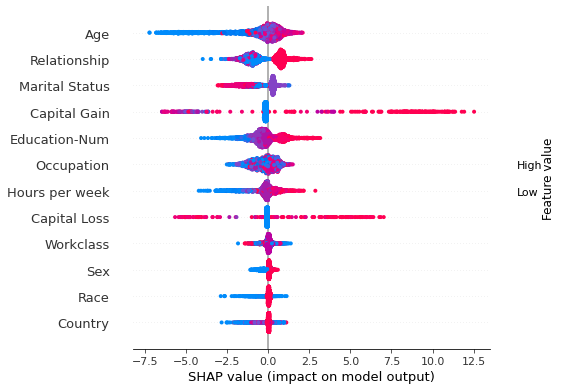

In [148]:
shap.summary_plot(shap_values)

In [135]:
shap_interaction_values.mean(0).sum(1).sum()

-2.00949

In [139]:
shap_values.values.mean(0).sum()

-2.009489

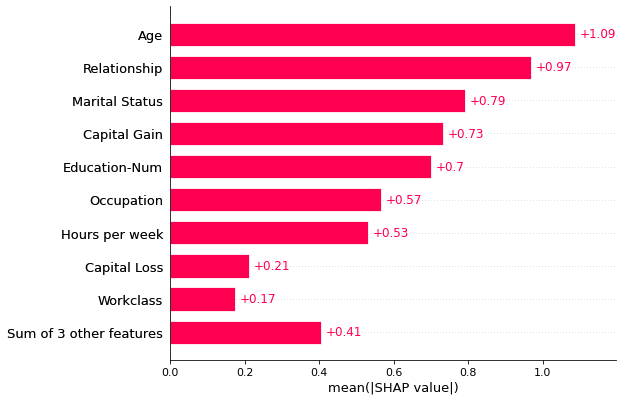

In [121]:
shap.plots.bar(shap_values)

In [13]:
score_methods = {
    'base': g_base,
    'abs': g_abs,
    'abs_interaction': g_abs_only_interaction,
    'ratio': g_ratio,
}
g_fn = score_methods['ratio']

# feature settings
feature_names = X_test.columns
magnitude = False
shap_interactions = shap_interaction_values

if shap_interactions.ndim == 3:
    # ndim == 3 case: global tree
    build_global = True
    siv = np.abs(shap_interactions).mean(0)
elif shap_interactions.ndim == 2:
    # ndim == 2 case: single tree
    build_global = False
    siv = shap_interactions if not magnitude else np.abs(shap_interactions)
else:
    raise ValueError('number of dimension of `shap_interactions` should be 2 or 3')

In [31]:
task_model = LinearRegression
eval_metric = r2_score

def get_new_X(X_original, nodes, feature_names):
    X = X_original.copy()
    for feature in nodes.keys():
        if isinstance(feature, int):
            continue
        feature_name = '+'.join([str(feature_names[i]) for i in flatten(feature)]) 
        X[feature_name] = X.iloc[:, flatten(feature)].prod(1)
    return X

def fit_poly(task_model, eval_metric, X_train, X_test, y_train, y_test):
    poly_model = task_model()
    poly_model.fit(X_train, y_train)
    y_pred = poly_model.predict(X_test)
    return eval_metric(y_test, y_pred)
    
def filter_scores(scores, existed_cmbs=None):
    filtered = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    if existed_cmbs is not None:
        filtered = [(key, value) for key, value in filtered if key not in existed_cmbs]
    return list(map(lambda x: x[0], filtered[:int(len(filtered)/2)]))

def cal_values(siv, cmbs):
    r, c = list(zip(*itertools.product(flatten(cmbs), flatten(cmbs))))
    return siv[r, c].sum()

def get_scores(nodes_to_run, siv_scores):
    scores = {}
    nodes = deepcopy(nodes_to_run)

    for cs in itertools.combinations(nodes, 2):
        if cs not in scores.keys():
            r, c = list(zip(*itertools.product(flatten(cs), flatten(cs))))
            scores[cs] = siv_scores[r, c].sum()
    return scores

infos = defaultdict(dict)

thres = 0.1
k = 0
n_select = 5

siv_scores = g_fn(shap_interactions, build_global)
r_diag, c_diag = np.diag_indices(len(feature_names))
main_effect = siv[r_diag, c_diag]
main_scores = siv_scores[r_diag, c_diag]

n_features = siv_scores.shape[1]

infos[k]['nodes'] = [dict()]
infos[k]['done'] = [set()]

for i, name in enumerate(feature_names):
    infos[k]['nodes'][0][i] = Node(name=name, parent=None, value=main_effect[i])

nodes_to_run = [key for key in infos[k]['nodes'][0].keys() if key not in infos[k]['done']]
infos[k]['nodes_to_run'] = [nodes_to_run]

y_pred = model.predict(xgb.DMatrix(X_test, y_test))
performance = r2_score(y_test, y_pred)

infos[k]['performance'] = performance

In [53]:
k += 1
if infos.get(k) is None:
    infos[k]['nodes'] = []
    infos[k]['done'] = []
    infos[k]['nodes_to_run'] = []
    infos[k]['performance'] = []

In [54]:
prev_nodes_to_run = deepcopy(infos[k-1]['nodes_to_run'])
prev_nodes = deepcopy(infos[k-1]['nodes'])
prev_dones = deepcopy(infos[k-1]['done'])

prev_nodes_to_run

[]

In [52]:
while prev_nodes_to_run:
    nodes_to_run = prev_nodes_to_run.pop(0)
    nodes = prev_nodes.pop(0)
    done = prev_dones.pop(0)
    existed_cmbs = list(filter(lambda x: isinstance(x, tuple), nodes.keys()))
    scores = get_scores(nodes_to_run, siv_scores)
    filtered_keys = filter_scores(scores, existed_cmbs)
    print(f'{nodes_to_run}: {filtered_keys}')
    for j, cmbs in enumerate(filtered_keys):
        new_nodes = deepcopy(nodes)
        new_done = deepcopy(done)

        v = cal_values(siv, cmbs)
        
        if feature_names is not None:
            feature_name = '+'.join([str(feature_names[i]) for i in flatten(cmbs)])
        else:
            feature_name = '+'.join(map(str(cmbs)))
        
        children = [new_nodes[c] for c in cmbs]
        new_nodes[cmbs] = Node(name=feature_name, value=v, children=children)
        infos[k]['nodes'].append(new_nodes)

        # add impossibles
        for c in cmbs:
            new_done.add(c)

        infos[k]['done'].append(new_done)
        new_nodes_to_run = [k for k in new_nodes.keys() if k not in new_done]
        infos[k]['nodes_to_run'].append(new_nodes_to_run)

# eval
for nodes in infos[k]['nodes']:
    new_X_train = get_new_X(X_train, nodes, feature_names)
    new_X_test = get_new_X(X_test, nodes, feature_names)
    performance = fit_poly(task_model, eval_metric, new_X_train, new_X_test, y_train, y_test)
    infos[k]['performance'].append(infos[0]['performance'] - performance)

sorted_idx = np.argsort(infos[k]['performance'])[::-1]

infos[k]['nodes_to_run'] = np.array(infos[k]['nodes_to_run'], dtype=object)[sorted_idx[:n_select]].tolist()
infos[k]['nodes'] = np.array(infos[k]['nodes'], dtype=object)[sorted_idx[:n_select]].tolist()
infos[k]['done'] = np.array(infos[k]['done'], dtype=object)[sorted_idx[:n_select]].tolist()

[5, ((1, 3), (4, ((0, 2), (6, 7))))]: []
[5, ((1, 3), (4, ((0, 2), (6, 7))))]: []
[5, ((1, 3), (7, (4, (6, (0, 2)))))]: []
[5, ((1, 3), ((0, 2), (4, (6, 7))))]: []
[5, ((1, 3), ((0, 2), (4, (6, 7))))]: []


In [22]:
filtered_keys

[(0, (6, 7)),
 (5, (6, 7)),
 (2, (6, 7)),
 (1, (6, 7)),
 (3, (6, 7)),
 (4, (6, 7)),
 (3, 4),
 (1, 5),
 (2, 3),
 (1, 3)]

In [11]:
tree_str = ''
for pre, fill, node in RenderTree(root):
    tree_str += f'{pre}{node.name}(v={node.value:.4f})\n'

In [12]:
print(tree_str)

MedInc+AveRooms(v=0.6202)
├── MedInc(v=0.4452)
└── AveRooms(v=0.1082)



In [ ]:

    def _build_tree(
            self, 
            nodes: Dict[Any, Node], 
            scores: Dict[Any, float], 
            values: Dict[Any, float], 
            done: Set, 
            g_fn: Callable, 
            top_n: int
        ):
        """Recursive function to build a bottom-up tree

        Args:
            nodes (Dict[Any, Node]): nodes with combinations of features as key, Node as value. \n
            scores (Dict[Any, float]): shap interaction scores with combinations of features as key, score as value. \n
            values (Dict[Any, float]): shap interaction values with combinations of features as key, summation of shap value as value. \n
            done (Set): record for used nodes. \n
            g_fn (Callable): a method function to process scores. \n
            top_n (int): top n scores to select from scores. \n

        """        
        nodes_to_run = [k for k in nodes.keys() if k not in done]
        if len(nodes_to_run) == 1:
            return nodes
        else:
            # update `scores` and `values`
            scores, values = self._get_scores(
                nodes_to_run, 
                siv_scores=self.siv_scores, 
                siv=self.siv, 
                scores=scores, 
                values=values
            )
            # select top_n nodes
            selected_cmbs = self._select(scores, top_n=top_n)
            for best_cmbs in selected_cmbs:
                # create node
                if self.feature_names is not None:
                    feature_name = '+'.join([str(self.feature_names[i]) for i in flatten(best_cmbs)])
                else:
                    feature_name = str(best_cmbs)
                
                children = [nodes[c] for c in best_cmbs]  
                nodes[best_cmbs] = Node(name=feature_name, value=values[best_cmbs], score=scores[best_cmbs], children=children)
                
                # add done and need to remove all impossible options for 'scores'
                for c in best_cmbs:
                    done.add(c)
                    impossible_coor = list(filter(lambda x: c in x, scores.keys()))
                    for coor in impossible_coor:
                        scores.pop(coor, None)
                        values.pop(coor, None)

                self._apply_record(nodes)
    
            return self._build_tree(nodes, scores, values, done, g_fn, top_n)

In [2]:
import pygad

In [ ]:
function_inputs = [4,-2,3.5,5,-11,-4.7]
desired_output = 44

In [ ]:
def fitness_func(solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness